# Traditional machine learning algorithms to classify audio

In [ ]:
import gc
import glob
import logging
import os
import random
import re
import sys
import time
import warnings
from concurrent.futures import ThreadPoolExecutor
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import (
    RandomizedSearchCV,
    StratifiedKFold,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.ERROR)

os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [ ]:
# data_dict = np.load('/kaggle/input/train-data-npy/train_data.npy', allow_pickle=True).item()
data_dict = np.load('dataset/train_data.npy', allow_pickle=True).item()

X_list = []
y_list = []
for fid, content in data_dict.items():
    mel_2d = content['data']  # shape (128,256)
    label_str = content['label']

    # Flatten from (128,256) => (32768,)
    mel_1d = mel_2d.flatten()

    X_list.append(mel_1d)
    y_list.append(label_str)

X_array = np.array(X_list)  # shape (N, 128*256)
y_array = np.array(y_list)  # shape (N,)

print("X_array shape:", X_array.shape)   # e.g. (N, 32768)
print("y_array shape:", y_array.shape)   # e.g. (N,)
print("Example label:", y_array[0])

X_array shape: (28564, 32768)
y_array shape: (28564,)
Example label: greani1


## PCA

Text(0, 0.5, 'Cumulative explained variance')

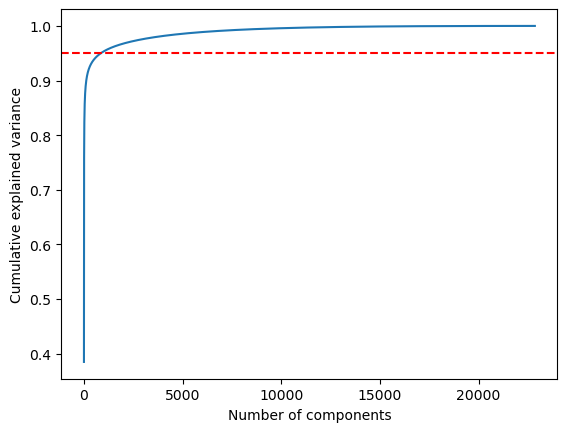

In [ ]:
pca = PCA().fit(X_array)
explained = np.cumsum(pca.explained_variance_ratio_)
plt.plot(explained)
plt.axhline(y=0.95, color='r', linestyle='--')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

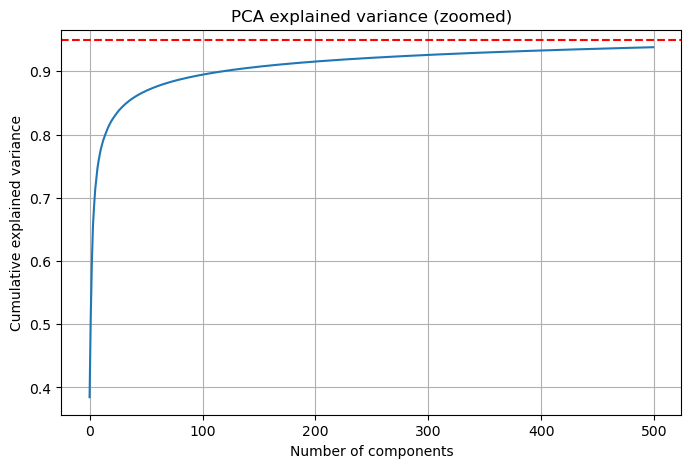

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(explained[:500])
plt.axhline(y=0.95, color='r', linestyle='--')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA explained variance (zoomed)')
plt.grid(True)
plt.show()

In [ ]:
n_95 = np.argmax(explained >= 0.95) + 1
print(f"95% variance is explained by {n_95} components")

n_85 = np.argmax(explained >= 0.85) + 1
print(f"85% variance is explained by {n_85} components")

95% variance is explained by 856 components
85% variance is explained by 34 components


In [25]:
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_array, y_array, stratify=y_array, test_size=0.2, random_state=42
)

# 标签编码
le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)
y_test = le.transform(y_test_raw)

# PCA 处理（注意这里对 train 做 fit，再 transform test）
pca = PCA(n_components=34)
X_train_pca = pca.fit_transform(X_train_raw)
X_test_pca = pca.transform(X_test_raw)

## RF

In [ ]:
# baseline
rf = RandomForestClassifier(
    n_estimators=50,
    max_depth=15,
    min_samples_leaf=3,
    n_jobs=2,
    random_state=42
)

rf.fit(X_train_pca, y_train)

y_pred = rf.predict(X_test_pca)

acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", acc)
print(classification_report(y_test, y_pred))

joblib.dump(rf, 'rf_baseline_model.pkl')
print("Model saved to rf_baseline_model.pkl")

Test Accuracy: 0.12952914405741292
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      1.00      1.00         1
           2       0.00      0.00      0.00         1
           3       1.00      0.50      0.67         2
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       1.00      0.25      0.40         4
           8       1.00      1.00      1.00         1
           9       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         1
          12       0.56      0.45      0.50        11
          13       0.00      0.00      0.00         7
          14       0.00      0.00      0.00        14
          15       0.00      0.00      0.00        10
          16       1.00      1.00      1.00         1
          17       0.00      0.00      0.00         1
          18       0.00      0.00      0.00   

In [ ]:
gc.collect()
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'max_features': ['sqrt', 'log2'],
}

random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_grid,
    n_iter=15,
    cv=3,
    scoring='accuracy',
    verbose=2,
    random_state=42,
    n_jobs=2
)

random_search.fit(X_train_pca, y_train)
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test_pca)

acc = accuracy_score(y_test, y_pred)
print("Best Parameters:", random_search.best_params_)
print("Test Accuracy:", acc)
print(classification_report(y_test, y_pred))
joblib.dump(best_rf, "best_rf_model.pkl")

Fitting 3 folds for each of 15 candidates, totalling 45 fits


## xgboost

In [9]:
%pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
    --------------------------------------- 2.9/150.0 MB 21.0 MB/s eta 0:00:08
   - -------------------------------------- 6.8/150.0 MB 18.3 MB/s eta 0:00:08
   --- ------------------------------------ 12.3/150.0 MB 20.3 MB/s eta 0:00:07
   ---- ----------------------------------- 17.0/150.0 MB 21.5 MB/s eta 0:00:07
   ----- ---------------------------------- 21.2/150.0 MB 20.6 MB/s eta 0:00:07
   ------ --------------------------------- 25.2/150.0 MB 20.4 MB/s eta 0:00:07
   ------- -------------------------------- 29.1/150.0 MB 20.3 MB/s eta 0:00:06
   --------- ------------------------------ 33.8/150.0 MB 20.4 MB/s eta 0:00:06
   ---------- ----------------------------- 39.1/150.0 MB 21.2 MB/s eta 0:00:06
   ----------- ---------------------------- 43.5/150.0 MB 21.1 MB/s eta 0:00:06
   ------------ --------------------------- 47.4/150.


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from xgboost import XGBClassifier

xgb_baseline = XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_jobs=8,
    random_state=42
)

xgb_baseline.fit(X_train_pca, y_train)

y_pred = xgb_baseline.predict(X_test_pca)

acc = accuracy_score(y_test, y_pred)
print("XGBoost Baseline Accuracy:", acc)
print(classification_report(y_test, y_pred))

joblib.dump(xgb_baseline, "xgb_baseline_model.pkl")
print("✅ Baseline XGBoost model saved to xgb_baseline_model.pkl")

XGBoost Baseline Accuracy: 0.14965867320147033
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      1.00      1.00         1
           2       0.00      0.00      0.00         1
           3       1.00      1.00      1.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          12       0.45      0.33      0.38        15
          13       0.50      0.22      0.31         9
          14       0.33      0.09      0.14        11
          15       0.50      0.22      0.31         9
          16       1.00      1.00      1.00         1
          17       0.00      0.00      0.00         1
          18       0.00      0.00 

In [ ]:
gc.collect()
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=len(np.unique(y_train)),
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_jobs=2,
    random_state=42
)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=20,
    scoring='accuracy',
    cv=cv,
    verbose=2,
    random_state=42,
    n_jobs=2
)

random_search.fit(X_train_pca, y_train)

best_model = random_search.best_estimator_
joblib.dump(best_model, "xgb_best_model.pkl")
print("✅ Best XGBoost model saved to xgb_best_model.pkl")

y_pred = best_model.predict(X_test_pca) # type: ignore
acc = accuracy_score(y_test, y_pred)
print("Best XGBoost Accuracy:", acc)
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
✅ Best XGBoost model saved to xgb_best_model.pkl
Best XGBoost Accuracy: 0.18134080168037808
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      1.00      1.00         1
           2       0.00      0.00      0.00         1
           3       0.50      1.00      0.67         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         0
          12       0.38      0.40      0.39        15
          13       0.33      0.22      0.27         9
          14       0.67      0.18      0.29        11
          15       0.67      0.22   

## LR

In [30]:
gc.collect()
baseline_lr = LogisticRegression(
    multi_class='multinomial',
    solver='saga',
    penalty='l2',
    max_iter=500,
    n_jobs=-1,
    random_state=42
)

baseline_lr.fit(X_train_pca, y_train)
y_pred_base = baseline_lr.predict(X_test_pca)
print("Baseline Accuracy:", accuracy_score(y_test, y_pred_base))

param_grid = {
    'C': np.logspace(-3, 1, 30),
    'penalty': ['l1', 'l2'],
    'solver': ['saga']
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=baseline_lr,
    param_distributions=param_grid,
    n_iter=20,
    scoring='accuracy',
    cv=skf,
    verbose=1,
    random_state=42,
    n_jobs=2
)

random_search.fit(X_train_pca, y_train)

best_lr = random_search.best_estimator_
print("Best Params:", random_search.best_params_)

joblib.dump(best_lr, 'best_logistic_regression.pkl')
print("Model saved to 'best_logistic_regression.pkl'")

y_pred_final = best_lr.predict(X_test_pca) # type: ignore
acc_final = accuracy_score(y_test, y_pred_final)
print("Final Accuracy after tuning:", acc_final)

Baseline Accuracy: 0.12042709609662174
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Params: {'solver': 'saga', 'penalty': 'l1', 'C': 0.3039195382313198}
Model saved to 'best_logistic_regression.pkl'
Final Accuracy after tuning: 0.11990197794503764
